# Простейшие нейронные сети на PyTorch

In [28]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
!git clone https://github.com/RiskModellingResearch/DeepLearning_Winter22.git

Cloning into 'DeepLearning_Winter22'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.10.0+cu111


In [3]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [4]:
X = pd.read_csv('DeepLearning_Winter22/week_01/data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('DeepLearning_Winter22/week_01/data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,Domestic,Shorthair,Longhair,Year,Month,Day,Hour,Breed_Chihuahua Shorthair Mix,Breed_Domestic Medium Hair Mix,Breed_Domestic Shorthair Mix,Breed_German Shepherd Mix,Breed_Labrador Retriever Mix,Breed_Pit Bull Mix,Breed_Rare,Sex_Female,Sex_Male,Sex_Unknown,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,0,0,0,2014,2,12,14.366667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,1,1,0,2013,10,13,8.733333,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,0,0,0,2015,1,31,9.466667,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,1,1,0,2014,7,11,15.150000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,0,0,0,2013,11,15,8.866667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [5]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [6]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [8]:
len(y)

26729

In [9]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить больших монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построим наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [11]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [12]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.0690598459112488

In [14]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708425, 0.06705575, 0.04653729, 0.69932271],
       [0.71548244, 0.02923483, 0.10843301, 0.14684972],
       [0.52376852, 0.03810022, 0.18068458, 0.25744667],
       ...,
       [0.77510328, 0.01024992, 0.1760185 , 0.0386283 ],
       [0.22847273, 0.05774407, 0.03826696, 0.67551624],
       [0.66540524, 0.03012254, 0.12082845, 0.18364377]])

### Случайный лес 

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7615185925416682

Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [16]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

# Пример библиотеки использования верхнеуровневого API

# FAST.AI

In [17]:
from fastai.tabular.all import *

Загрузим датасет, где необходимо предсказать, будет ли человек зарабатывать больше $50K в год.

In [18]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/export.pkl')]

In [59]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [60]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize],
    bs=BATCH_SIZE)

In [21]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [22]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [23]:
dls = to.dataloaders(bs=BATCH_SIZE)

In [24]:
learn = tabular_learner(dls, metrics=accuracy)

In [25]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.407687,0.373448,0.825860,00:02
1,0.358966,0.353765,0.835688,00:02


In [26]:
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,1.0,12.0,5.0,1.0,5.0,3.0,1.0,-0.408719,0.001496,-0.419762,0.0,0.0
1,5.0,10.0,3.0,5.0,1.0,5.0,1.0,0.766140,-0.390647,1.141846,1.0,1.0
2,7.0,8.0,4.0,5.0,2.0,5.0,1.0,1.647285,0.330097,0.751444,0.0,0.0
3,1.0,1.0,6.0,1.0,4.0,5.0,1.0,-0.041575,-0.574049,-1.590968,0.0,0.0
4,5.0,12.0,3.0,15.0,1.0,5.0,1.0,-0.996149,0.098790,-0.419762,0.0,0.0
5,5.0,12.0,1.0,13.0,5.0,3.0,1.0,1.206713,-0.439591,-0.419762,0.0,0.0
6,6.0,11.0,3.0,11.0,1.0,5.0,1.0,-0.408719,0.464668,2.313052,0.0,1.0
7,3.0,16.0,3.0,12.0,1.0,5.0,1.0,-0.702434,1.832952,-0.029360,1.0,0.0
8,5.0,2.0,1.0,8.0,3.0,5.0,1.0,1.941000,-0.385144,-1.200566,0.0,0.0


In [27]:
row, clas, probs = learn.predict(df.iloc[0])

In [28]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101320.003008,12.0,<50k


# Vanilla PyTorch

Код представленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтому на первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

In [41]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y,
                                                    test_size=0.2, stratify=y, random_state=42)

Создание __DataLoader__ для обучения сети

In [43]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

In [44]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [45]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE)
    )

    return model

In [46]:
model = build_model()

In [47]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
)


Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [48]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()
softmax = nn.Softmax()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [49]:
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        model.train()
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()
            
            softmax_output = softmax(output)
            acc = accuracy(softmax_output, label).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        model.eval()
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label)
            
            softmax_output = softmax(output)
            acc = accuracy(softmax_output, label).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [50]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.328627 train_acc: 0.352101
EPOCH 0 : valid_loss: 1.303204 valid_acc: 0.352455
EPOCH 20 : train_loss: 1.218306 train_acc: 0.402231
EPOCH 20 : valid_loss: 1.217744 valid_acc: 0.402833
EPOCH 40 : train_loss: 1.208902 train_acc: 0.403838
EPOCH 40 : valid_loss: 1.209959 valid_acc: 0.402833
EPOCH 60 : train_loss: 1.201845 train_acc: 0.402231
EPOCH 60 : valid_loss: 1.202229 valid_acc: 0.402833
EPOCH 80 : train_loss: 1.193662 train_acc: 0.403838
EPOCH 80 : valid_loss: 1.194476 valid_acc: 0.402833


 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

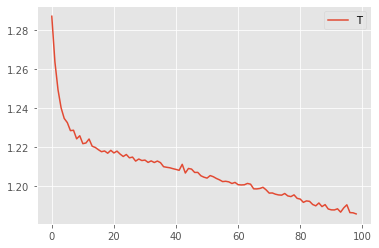

In [51]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

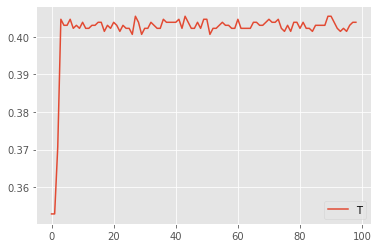

In [52]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

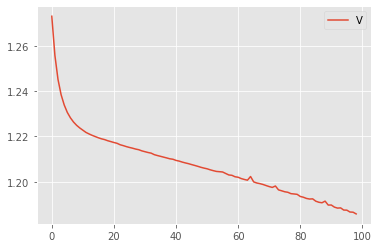

In [53]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

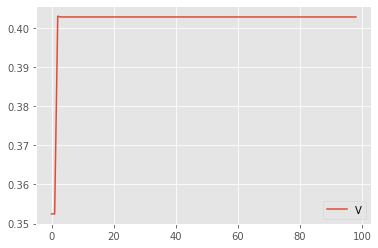

In [54]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [55]:
torch.save(model, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [56]:
model = torch.load('simple_nn.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=4, bias=True)
)

In [57]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
    softmax_output = softmax(test_scores)
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.4029180705547333
[[ 1.0947459  -0.85005283  0.03521759  0.9419442 ]
 [ 1.0525479  -0.8430326   0.08657841  0.9193269 ]
 [ 1.0955994  -0.85051185  0.03568073  0.94187486]
 ...
 [ 1.0565691  -0.84183866  0.08257534  0.92164475]
 [ 1.0958934  -0.8506699   0.03584021  0.94185114]
 [ 1.0365248  -0.8186418   0.00372189  0.94607747]]


In [58]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = model(torch.tensor(X_test.astype(np.float32)))
    softmax_output = softmax(test_scores)
predicted_classes = torch.argmax(softmax_output, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 0, 0, 0])
